# Pre-training of GPT-2-124-million 
- add the following bells and whistles to the base version
    - learning rate warmup
    - cosine decay
    - gradient clipping
- load pre-trained model from pretrain.ipynb

In [1]:
import torch

In [2]:
import numpy as np
import os
import sys 
import math
from typing import Tuple, Dict, List

cwd = os.getcwd()

In [4]:
print(torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

from torch.utils.data import Dataset, DataLoader
import torch.nn as nn 
import torch.nn.functional as F

2.2.1
Using device: cpu


## preprocess

In [5]:
# load tokenizer
import importlib
import tiktoken
print("tiktoken version:", importlib.metadata.version("tiktoken"))
tokenizer = tiktoken.get_encoding("gpt2")

tiktoken version: 0.6.0


In [6]:
# read in raw text
pdata = f"{cwd[:-18]}traditional-NLP/data/"
sys.path.append(pdata)
with open(f"{pdata}anna.txt" , 'r', encoding='utf-8') as f:
    text_data = f.read()
print(f"The type of the raw text: {type(text_data)}")
print(f"The beginning of raw text: \n {text_data[:50]}")

The type of the raw text: <class 'str'>
The beginning of raw text: 
 Chapter 1


Happy families are all alike; every un


In [7]:
# inspect raw text and tokens
total_characters = len(text_data)
print(f"total num of characters in Anna Karenina: {total_characters}")
total_tokens = len(tokenizer.encode(text_data))
print(f"total num of tokens in Anna Karenina with BPE tokenizer: {total_tokens}")
# total num of characters in Anna Karenina: 1985223
# total num of tokens in Anna Karenina with BPE tokenizer: 508206

total num of characters in Anna Karenina: 1985223
total num of tokens in Anna Karenina with BPE tokenizer: 508206


### set parameters

In [8]:
CONFIG_GPT2_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

torch.manual_seed(123)

### torch dataset dataloader

In [9]:
# create dataset and dataloader

class my_text_dataset(Dataset):

    # initialize with n varg in
    def __init__(self, raw_text:str, tokenizer, max_length:int, stride:int=1):
        # create class attributes
        self.input_tokens_x = []
        self.target_tokens_y = []

        # tokenize the enitre text 
        tokens = tokenizer.encode(raw_text, allowed_special={"<|endoftext|>"})

        # set y as stride number of tokens trailing x 
        for i in range(0, (len(tokens)-max_length), stride):
            x_tmp = tokens[i : (i+max_length)]
            y_tmp = tokens[(i+1) : (i+max_length+1)]
            self.input_tokens_x.append(torch.tensor(x_tmp))
            self.target_tokens_y.append(torch.tensor(y_tmp))

    # overwrite the __len__() method to return number of rows in the dataset
    def __len__(self) -> int:
        "Returns the number of rows / pairs of x-y sequences in the dataset"
        return len(self.input_tokens_x)
    
    # overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)."
        return self.input_tokens_x[idx], self.target_tokens_y[idx]

def my_text_dataloader(raw_text:str, batch_size:int=4, max_length:int=256,
                       stride:int=128, shuffle=True, drop_last=True, num_workers=0):
    # initialize the tokenizer
    tokenizer = tiktoken.get_encoding("gpt2")

    # create dataset
    dataset = my_text_dataset(raw_text, tokenizer, max_length, stride)

    # create dataloader
    dataloader = DataLoader(
        dataset, batch_size=batch_size, shuffle=shuffle, drop_last=drop_last, num_workers=num_workers)

    return dataloader

#### split into T, V, H

In [10]:
total_characters = len(text_data)
print(f"total num of characters in Anna Karenina: {total_characters}")
prop_t, prop_v, prop_h = (0.8,0.1,0.1)
split_idx_t, split_idx_v = int(prop_t * total_characters), int((prop_t+prop_v) * total_characters)
print(f"Split at character index {split_idx_t} between train and valid sets, and at {split_idx_v} betwee valid and hold sets")

d_train = text_data[:split_idx_t]
d_valid = text_data[split_idx_t:split_idx_v]
d_hold  = text_data[split_idx_v:]

assert (total_tokens * prop_t) > CONFIG_GPT2_124M["context_length"], "Not enough tokens for loader_t (training dataloader)"
assert (total_tokens * prop_v) > CONFIG_GPT2_124M["context_length"], "Not enough tokens for loader_v (validation dataloader)"
assert (total_tokens * prop_h) > CONFIG_GPT2_124M["context_length"], "Not enough tokens for loader_h (testing dataloader)"

total num of characters in Anna Karenina: 1985223
Split at character index 1588178 between train and valid sets, and at 1786700 betwee valid and hold sets


In [11]:
loader_t = my_text_dataloader(
    raw_text=d_train,
    batch_size=2, # this is only for learning purpose; in practice, batch_size >= 1024 is common
    max_length=CONFIG_GPT2_124M["context_length"],
    stride=CONFIG_GPT2_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

loader_v = my_text_dataloader(
    raw_text=d_valid,
    batch_size=2,
    max_length=CONFIG_GPT2_124M["context_length"],
    stride=CONFIG_GPT2_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

# loader_h = my_text_dataloader(
#     raw_text=d_hold,
#     batch_size=2,
#     max_length=CONFIG_GPT2_124M["context_length"],
#     stride=CONFIG_GPT2_124M["context_length"],
#     drop_last=False,
#     shuffle=False,
#     num_workers=0
# )

### inspect loaded data

In [12]:
train_tokens = 0
for input_batch, target_batch in loader_t:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in loader_v:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 406528
Validation tokens: 50944
All tokens: 457472


## modules and model
- key components:
    - tokenization - done in my_text_dataloader
    - input embedding
    - positional encoding
    - dropout
    - tansformer block
        - layernorm
        - multiheadattention CONFIG_GPT2_124M["n_heads"] by CONFIG_GPT2_124M["n_layers"]
        - droppout+shortcut
        - layernorm
        - feedford
        - dropout+shortcut
    - layernorm
    - output linear layer


### define modules

In [13]:
class Multihead_Causal_Attention(nn.Module):
    def __init__(self, d_in, d_out, context_length, n_heads, dropout_rate, qkv_bias=False):
        # inherit from the nn.Module parent 
        super().__init__() 

        # make sure d_out is divisible by n_heads (modulous ope, remainder==0)
        assert (d_out % n_heads == 0), "d_out must be divisible by n_heads"

        self.d_out = d_out
        self.n_heads = n_heads
        # floor division
        self.d_head = d_out // n_heads
        self.w_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.w_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.w_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        # add the buffer to create mask and send it to device with the model 
        # but not update it
        self.register_buffer(
            'mask',
            torch.triu(
                torch.ones(context_length,context_length),
                diagonal=1)
        )
        # add the dropout - object from nn.Dropout with param dropout_rate
        self.dropout = nn.Dropout(dropout_rate)
        # add linear layer to combine heads out
        self.combine_heads = nn.Linear(d_out, d_out)
    

    def forward(self, x):
        # allowing batching: first is the batch dim of tensors
        batch, n_tokens, d_in = x.shape

        # initialize the w_query, w_key, w_value 
        # AND matmul with input embeddings x
        queries = self.w_query(x)
        keys = self.w_key(x)
        values = self.w_value(x)

        # ###### split weights for the heads ######
        # dims from (batch, n_tokens, d_out) 
        # to (batch, n_tokens, n_heads, d_head)
        queries = queries.view(batch, n_tokens, self.n_heads, self.d_head)
        keys = keys.view(batch, n_tokens, self.n_heads, self.d_head)
        values = values.view(batch, n_tokens, self.n_heads, self.d_head)
        # then to (batch, n_heads, n_tokens, d_head)
        queries = queries.transpose(1,2)
        keys = keys.transpose(1,2)
        values = values.transpose(1,2)
        # ###### split weights for the heads ######

        # attention score query @ key.T 
        # but remember the dims is (batch, n_tokens, n_heads, d_head) so transpose the last two
        # !!! this computes dot product for each head !!!
        attention_scores = torch.matmul(queries, keys.transpose(2, 3))

        # add causal attention masks 
        # computeation with trailing underscore are performed in-place
        attention_scores.masked_fill_(
            # change the mask to boolean (truncated to num of tokens)
            self.mask.bool()[:n_tokens, :n_tokens],
            # fill value when 1 in mask
            -torch.inf
        )

        # attention weights = normalized attention scores
        # scale the attention scores by the sqrt(embedding dimentsion) first 
        # to improve the training performance by avoiding small gradients.
        attention_weights = torch.softmax(
            attention_scores / (keys.shape[-1]**0.5),
            dim=-1
        )

        # apply dropout to attention weights 
        attention_weights = self.dropout(attention_weights)

        # calculate context vector attention weights @ values
        # ###### combine across all heads  ######
        # dims (batch, n_heads, n_tokens, d_head) to (batch, n_tokens, n_heads, d_head)
        context_vectors = torch.matmul(attention_weights, values).transpose(1, 2)
        context_vectors = context_vectors.contiguous().view(
            batch, n_tokens, self.d_out
        )
        # Combines heads, where self.d_out= self.n_heads * self.d_head
        context_vectors = self.combine_heads(context_vectors)
        # ###### combine across all heads  ######


        return context_vectors

In [14]:
# nn.LayerNorm(emb_dim)
# if we code it out it does the following
# each mini-batch in the scenario is all the input embeddings of one context 
# mean and var came from calc across columns of the emsbeddings for each token
# then scale and shif provides a linear transformation
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        # unlike buffers, Parameters will be updated
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

In [15]:
# nn.GELU()
# when coding it out, it looks like the following
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

In [16]:
# feed forward netword after multihead attention in each transformer block
# why does this particular architecture have a 4 x expansion and shrinkage?
class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(config["emb_dim"], 4 * config["emb_dim"]),
            GELU(),
            nn.Linear(4 * config["emb_dim"], config["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

In [17]:
class TransformerBlock(nn.Module):
    """
    Follows the architecture of GPT-2-124_million
    Decoder only transformer

    - tansformer block
        - layernorm
        - multiheadattention CONFIG_GPT2_124M["n_heads"] by CONFIG_GPT2_124M["n_layers"]
        - droppout
        - shortcut
        - layernorm
        - feedford
        - dropout
        - shortcut
    """

    def __init__(self, config):
        super().__init__()

        self.lnorm1 = LayerNorm(config["emb_dim"])
        self.mhca = Multihead_Causal_Attention(d_in=config["emb_dim"], 
                                               d_out=config["emb_dim"], 
                                               context_length=config["context_length"], 
                                               n_heads=config["n_heads"], 
                                               dropout_rate=config["drop_rate"])
        self.drop_out = nn.Dropout(p=config["drop_rate"])
        self.lnorm2 = LayerNorm(config["emb_dim"])
        self.ff = FeedForward(config)

    def forward(self, x):
        # define shortcut / residual connection for attenion block
        residual_conn = x
        # layer norm before attention
        x = self.lnorm1(x)
        # multihead causal attention
        x = self.mhca(x)
        # dropout 
        x = self.drop_out(x)
        # shortcut / residual connection
        x = x + residual_conn

        # define residual for FeedForward block
        residual_conn = x
        # layer norm
        x = self.lnorm2(x)
        # feedforward
        x = self.ff(x)
        # drop_out
        x = self.drop_out(x)
        # residual connection
        x = x + residual_conn
        return x

### define model

In [18]:
# put it all together into a model 
class GPT2_124_model(nn.Module):
    """
    - input embedding
    - positional encoding
    - dropout
    - tansformer block
    - layernorm
    - output linear layer
    """
    def __init__(self, config):
        super().__init__()
        # input embedding
        self.input_emb = nn.Embedding(num_embeddings=config["vocab_size"],
                                      embedding_dim=config["emb_dim"])
        # absolute positional encoding
        self.pos_emb = nn.Embedding(num_embeddings=config["context_length"], 
                                    embedding_dim=config["emb_dim"])
        # TO TRY RoPE
        # from torchtune.modules import RotaryPositionalEmbeddings
        # rope_dim = config["emb_dim"]/config["n_head"]
        # self.pos_emb = RotaryPositionalEmbeddings(dim=rope_dim)

        # dropout
        self.drop_out = nn.Dropout(p=config["drop_rate"])

        # transformer block x n_layers times
        self.transformer_block = nn.Sequential(
            # unpack list comprehension to repeat transformer-block n_layers times
            *[TransformerBlock(config) for _ in range(config["n_layers"])]
        )    

        # layer norm
        self.lnorm = LayerNorm(config['emb_dim'])

        # final output layer
        # expand tokens into logits in vocab_size dimensions
        # do not add extra bias 
        self.out_layer = nn.Linear(in_features=config["emb_dim"],
                                   out_features=config["vocab_size"],
                                   bias=False)
    
    def forward(self, input_tokens):
        batch_size, seq_len = input_tokens.shape
        input_embeddings = self.input_emb(input_tokens)
        posit_embeddings = self.pos_emb(torch.arange(seq_len, device=input_tokens.device))
        # add positional encoding into input embedding 
        x = input_embeddings + posit_embeddings
        # dropout
        x = self.drop_out(x)
        # transformer block
        x = self.transformer_block(x)
        # layer norm
        x = self.lnorm(x)
        # final output layer -> logits
        logits = self.out_layer(x)
        return logits

## training loop
- A typical training loop
- loop through all training epochs
    - within each epoch, loop through all batches (n_batches = train_size / batch_size)
        - reset (from previous batch iter) the loss gradient to zero 
        - calculate loss on the current batch
        - backpropagate loss gradient 
        - step to update weight and biases for next loop of training
        - claculate training and validation losses
        - visualize losses and sample texts 

### define training eval funcs
- loss calculation under the hood:
    - get the logits from the transformer output layer
    - convert logits to probablities with softmax
    - get target probabilities 
    - take (-1) * log (probabilties) [ log(prob)<0 so maximize to 0 or (-1)* to minimize to 0 ]
    - take the cross entropy loss between predicted and target

In [19]:
# calculate loss per batch
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss

# function to compute loss per loader of data during training and validation
# as sum of loss across all batches in the dataloader / number of batches
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    # get the number of batches to compute the loss
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        # iterate over all batches in the dataloader unless num_batches is otherwise given
        num_batches = len(data_loader)
    else:
        # Reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))

    # compute loss across batches 
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            # sum loss from each batch 
            total_loss += loss.item() 
        else:
            break
    return total_loss / num_batches

# calculate avg loss across train set and valid set respecitively
def evaluate_model(model, data_train, data_valid, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(data_train, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(data_valid, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

# encode example text to token ids
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

# decode example token ids to text 
def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (Batch, Token) array of indices in the current context
    for _ in range(max_new_tokens):

        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]

        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)

        # Focus only on the last time step
        # (batch, n_token, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]

        # Get the idx of the vocab entry with the highest logits value
        idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        # until reacing max_new_tokens
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

### load pre-trained (incomplete) model

In [20]:
# load & use checkpoint

torch.manual_seed(123)
checkpoint = torch.load("my_gpt2_mdl_optimizer.pth", weights_only=True)

model = GPT2_124_model(CONFIG_GPT2_124M)
model.load_state_dict(checkpoint["model_state_dict"])

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train()

GPT2_124_model(
  (input_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_out): Dropout(p=0.1, inplace=False)
  (transformer_block): Sequential(
    (0): TransformerBlock(
      (lnorm1): LayerNorm()
      (mhca): Multihead_Causal_Attention(
        (w_query): Linear(in_features=768, out_features=768, bias=False)
        (w_key): Linear(in_features=768, out_features=768, bias=False)
        (w_value): Linear(in_features=768, out_features=768, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
        (combine_heads): Linear(in_features=768, out_features=768, bias=True)
      )
      (drop_out): Dropout(p=0.1, inplace=False)
      (lnorm2): LayerNorm()
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
    )
    (1): TransformerBlock(
      (lnorm1): LayerNorm()
      (mhca): Mu

In [21]:
def training_loop(model,
                  data_train,
                  data_valid,
                  optimizer,
                  num_epochs,
                  device,
                  eval_frequency,
                  eval_iter,
                  start_context,
                  warmup_step_prop=0.2, 
                  initial_lr=3e-05, 
                  min_lr=1e-6,
                  tokenizer=tokenizer):
    """
    - loop through all training epochs
    - within each epoch, loop through all batches (n_batches = train_size / batch_size)
        - reset (from previous batch iter) the loss gradient to zero 
        - calculate loss on the current batch
        - backpropagate loss gradient 
        - step to update weight and biases for next loop of training
        - claculate training and validation losses
        - visualize losses and sample texts 
    """
    # declare lists to track losses
    train_losses, val_losses, track_tokens_seen, track_lrs = [], [], [], []
    tokens_seen, global_step = 0, -1
    # retrieve the initial learning rate from the optimizer as the peak lr
    peak_lr = optimizer.param_groups[0]["lr"]
    # if optimizer.param_groups[0]["lr"] > 0.01:
    #     peak_lr = optimizer.param_groups[0]["lr"]
    # else: 
    #     peak_lr = 0.01
    
    # cal the total num of steps/iteration across the whole training
    total_training_steps = len(data_train) * num_epochs
    # calc warm_up steps as a proportion to toal training steps
    warmup_steps = int(warmup_step_prop * total_training_steps)
    # calc lr warmup increatment 
    lr_increment = (peak_lr - initial_lr) / warmup_steps

    # main training loop
    # loop through all training epochs
    for epoch in range(num_epochs):
        # set model to training mode
        model.train()
        # loop through all batches 
        for input_batch, target_batch in data_train:
            # reset (from previous batch iter) the loss gradient to zero 
            optimizer.zero_grad()
            
            ##### add learning rate warm up ######
            # keep a count of global iterations (across batches and epochs) taken
            global_step += 1
            # update learning rate if still in the warmup phase
            if global_step < warmup_steps:
                lr = initial_lr + global_step * lr_increment
            else:
                # withtout cosine decay
                # lr = peak_lr
                # ##### with cosine decay #####
                progress = ((global_step - warmup_steps) /
                            (total_training_steps - warmup_steps))
                lr = min_lr + (peak_lr - min_lr) * 0.5 * (
                                1 + math.cos(math.pi * progress)
                                )
            for param_group in optimizer.param_groups:
                param_group["lr"] = lr
                track_lrs.append(optimizer.param_groups[0]["lr"])

            # calculate loss on the current batch
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            # backpropagate loss gradient 
            loss.backward()

            # ####### gradient clipping #######
            # Apply gradient clipping after the warmup phase to avoid exploding gradients
            if global_step > warmup_steps:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                
            # step to update weight and biases for next loop of training
            optimizer.step()
            # keep a count of the tokens seen 
            tokens_seen += input_batch.numel()
            
            global_step += 1

            # print out eval from train and valid data if global steps is divisible by eval_frequency
            if global_step % eval_frequency == 0:
                # get loss for eval_iter number of batches
                train_loss, val_loss = evaluate_model(
                    model, data_train, data_valid, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Epoch {epoch+1} (Global Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")
        
        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen


In [ ]:
# for gradient clipping, if we want to check a max gradient first
def find_highest_gradient(model):
    max_grad = None
    for param in model.parameters():
        if param.grad is not None:
            grad_values = param.grad.data.flatten()
            max_grad_param = grad_values.max()
        if max_grad is None or max_grad_param > max_grad:
            max_grad = max_grad_param
    return max_grad
print(find_highest_gradient(model))

### run training loop

In [22]:
import time
start_time = time.time()

torch.manual_seed(123)
# since we loaded previously trained (incomplete) model
# model = GPT2_124_model(CONFIG_GPT2_124M)
# model.to(device)
# # lr=0.0004
# # since warmup + cosine decay, increase the initial lr a bit lr=0.001
# optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.1)

start_context = "This is a test of the modified "

# set an extremely small epoch size for testing only
num_epochs = 2
train_losses, val_losses, tokens_seen = training_loop(model=model, 
                                                      data_train=loader_t, 
                                                      data_valid=loader_v, 
                                                      optimizer=optimizer, 
                                                      num_epochs=num_epochs,
                                                      device=device, 
                                                      eval_frequency=5, 
                                                      eval_iter=5,
                                                      start_context=start_context
                                                      )

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

# canceled training loop

Epoch 1 (Global Step 000005): Train loss 4.536, Val loss 4.580
Epoch 1 (Global Step 000015): Train loss 4.456, Val loss 4.576


KeyboardInterrupt: 

### alternative to loss

In [31]:
# The perplexity is often considered more interpretable 
# because it can be understood as the effective vocabulary size 
# that the model is uncertain about at each step 
# (in the example below, that'd be perplexity number of tokens)
perplexity = torch.exp(torch.tensor(val_losses[-1]))
print(f"Loss at example training Epoch 2 (Global Step 001585): Train loss 4.535, Val loss 4.582)")
print(f"Perplexity based on the latest validation loss is {perplexity:.2f}")
print(f"The effective vocabulary size that the model is uncertain about at this step is {perplexity:.2f}")

Loss at example training Epoch 2 (Global Step 001585): Train loss 4.535, Val loss 4.582)
Perplexity based on the latest validation loss is 97.66
The effective vocabulary size that the model is uncertain about at this step is 97.66


### visualize loss

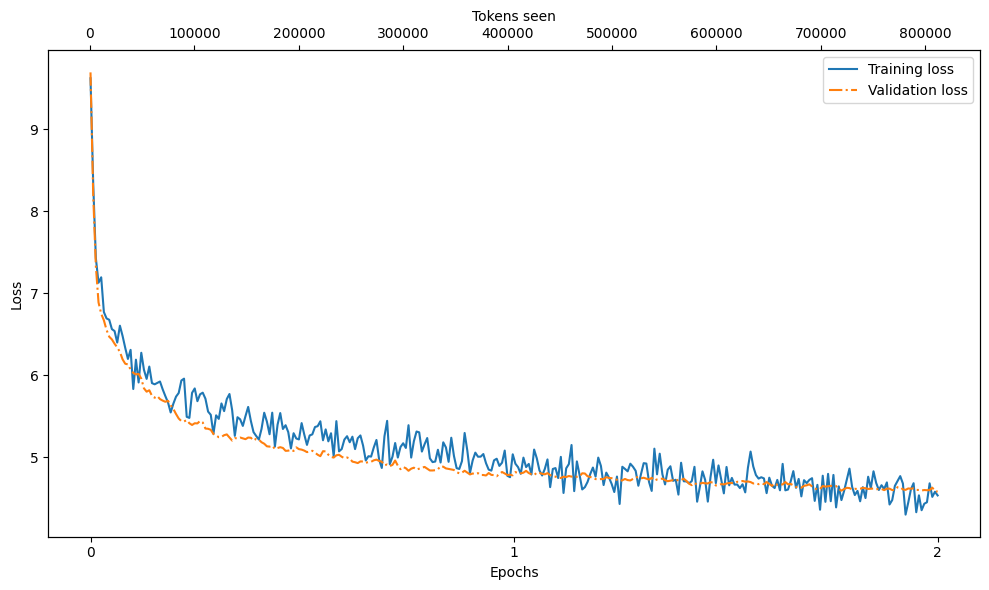

In [33]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

## save model + optimizer params

In [34]:
# save model only
# torch.save(model.state_dict(), "my_gpt2_mdl.pth")
# save model + optimizers
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    }, 
    "my_gpt2_mdl_optimizer.pth"
)

In [35]:
# load & use checkpoint

torch.manual_seed(123)
checkpoint = torch.load("my_gpt2_mdl_optimizer.pth", weights_only=True)

model = GPT2_124_model(CONFIG_GPT2_124M)
model.load_state_dict(checkpoint["model_state_dict"])

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train()

GPT2_124_model(
  (input_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_out): Dropout(p=0.1, inplace=False)
  (transformer_block): Sequential(
    (0): TransformerBlock(
      (lnorm1): LayerNorm()
      (mhca): Multihead_Causal_Attention(
        (w_query): Linear(in_features=768, out_features=768, bias=False)
        (w_key): Linear(in_features=768, out_features=768, bias=False)
        (w_value): Linear(in_features=768, out_features=768, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
        (combine_heads): Linear(in_features=768, out_features=768, bias=True)
      )
      (drop_out): Dropout(p=0.1, inplace=False)
      (lnorm2): LayerNorm()
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
    )
    (1): TransformerBlock(
      (lnorm1): LayerNorm()
      (mhca): Mu